In [1]:
import numpy as np
from hmmlearn import hmm
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [2]:
# define the hmm that generates the random states and observations
def model_gen(delta):
    """
    :param delta: float between 0.0 and 0.7 to control the flow
    :return: hmm model
    """
    components = 6
    delta = delta
    startprob = np.array([1, 0, 0, 0, 0, 0])
    transtprob = np.array([[0.1, 0.9, 0, 0, 0, 0],
                        [0.2, 0, 0.1+delta, 0, 0, 0.7-delta],
                        [0, 0.5, 0, 0.5, 0, 0],
                        [0, 0, 0.5, 0.5, 0, 0],
                        [0, 0, 0.1, 0, 0.4, 0.5],
                        [0, 0.2, 0, 0, 0.7, 0.1]])
    emissionprob = np.array([[0.25, 0.25, 0.25, 0.25],
                         [0.4, 0.3, 0.2, 0.1],
                         [0.4, 0.4, 0.1, 0.1],
                         [0.3, 0.3, 0.3, 0.1],
                         [0.2, 0.2, 0.2, 0.4],
                         [0.2, 0.2, 0.3, 0.3]
                         ])
    model = hmm.CategoricalHMM(n_components=components)
    model.transmat_ = transtprob
    model.emissionprob_ = emissionprob
    model.startprob_ = startprob
    return model

In [3]:
# get observation and latent states
def observation_sample(model_gen, k = 10):
    """
    :param model_gen: hmm model to generate from
    :param k: number of total states
    :return: [observations, latent states]
    """
    O, Q = model_gen.sample(k*2)
    observations = O[np.arange(0,2*k,2)].flatten()
    return observations, Q

## Random generation of states
The $\text{observation_sample_random}$ function generate the random observation with probabilities as shown in the histogram below.

In [ ]:
### INSERIRE ISTOGRAMMA

In [4]:
# generation of random observations
def observation_sample_random(k=10):
    observation =   np.random.choice(np.arange(0,4), p=[0.40, 0.40, 0.10, 0.10], size=k)
    return observation

In [5]:
# definition of Viterbi alg with obs every other state
def viterbi(obs, components, model):
    """
    :param obs: list of observations
    :param components: number of states
    :param model: hmm model
    :return: best states estimation
    """
    T = len(obs)*2
    V = np.zeros((T,components))
    for j in range(components):
        V[0][j] = model.startprob_[j]*model.emissionprob_[j][obs[0]]
    for t in range(1,T):
        for j in range(components):
            if t%2 == 0:
                V[t][j] = max(V[t-1] * model.transmat_[:,j] * model.emissionprob_[j][obs[int(t/2)]])
            else:
                V[t][j] = max(V[t-1] * model.transmat_[:,j])
    optimal_state = np.argmax(V[T-1])
    best_path = [optimal_state]
    for i in range(T-2,-1,-1):
        optimal_state = np.argmax(V[i-1]*model.transmat_[:,optimal_state])
        best_path.append(optimal_state)
    #print(f"The estimated path is: {best_path}")
    return np.array(best_path)

In [57]:
# define if for a list of states if the sequence is high risk
def high_states_check(path, m, high_states=[4,5]):
    """
    :param path: best estimation of states
    :param m: number of consecutives high risk states
    :param high_states: which states are considered high states
    :return: boolean
    """
    path_np = np.where(path >= min(high_states), 7, path)
    for i in range(len(path_np) - (int(m)+1)):
        if np.array_equal(path_np[i:i+int(m)+1], np.array([7]*(int(m)+1))):
            # print("Fuori controllo")
            return True
    return False

In [7]:
# generate and count how many of the n sequence are high risk
def high_risk_condition(model, components, m, k,n):
    """
    :param model: hmm model
    :param components: number of states
    :param m: number of consecutive high risk states
    :param k: number of states per run
    :param n: number of runs
    :return: list of boolean (True for high risk, False for not high risk)
    """
    cons_state = []
    for i in range(n):
        obs = observation_sample_random( k=k)
        cons_state.append(high_states_check(viterbi(obs=obs,components=components, model=model), m=m))
    return cons_state

In [101]:
def high_risk_condition_real_states(model,m,n):
    cons_state=[]
    for i in range(n):
        obs, real_states = observation_sample(model_gen=model, k=k)
        cons_state.append(high_states_check(real_states, m=m))
    return

In [8]:
# count the percentage of runs that are high risk
def f_critical(risk_list):
    """
    :param risk_list: list of boolean for risks
    :return: f value for being high risk
    """
    return sum(risk_list) / len(risk_list)

### Point a

Here the $\text{flow_control}$ function is developed. The function iteratively increment the value of $\Delta$ to control the flow in the system. Given a $\Delta_{start}$ and a $\Delta_{increment}$ the algorithm look if the system, given the random observations, is in a low risk state, if not the value of $\Delta$ is increased.
The function returns the number of steps necessary to reach a safe configuration.
If the maximum value of $\Delta$ is reached and the system does not result in a safe state the function return the value of 100.


In [9]:
# definition of parameters
components = 6
k = 200
n = 100
delta_start = 0.05
delta_increment = 0.01
delta_max = 0.70
m = 5
f = 0.1


In [10]:
def flow_control(f, m, n, k, components, delta_start= 0.05, delta_inc= 0.01, delta_max = 0.70 ):
    delta = delta_start
    in_control = False
    iter = 0
    while (delta <= delta_max) and not(in_control):
        iter += 1
        risk_state = f_critical(high_risk_condition(model= model_gen(delta), components=components, m=m, k=k, n=n))
        if risk_state >= f:
            print(f"{'#'*10}\nThe system is not in control\nDelta : {delta:.2f}\n{'#'*10}")
            delta += delta_inc
        else:
            in_control = True
            print(f"{'#'*10}\nSystem is in control with Delta : {delta:.2f}\n{'#'*10}")
            return iter-1
    print(f"\n\nThe system cannot converge to a good state changing delta")
    return 100

In [11]:
iters = flow_control(f=0.1, m=5, n=100, k=200, components=6)

##########
The system is not in control
Delta : 0.05
##########
##########
The system is not in control
Delta : 0.06
##########
##########
The system is not in control
Delta : 0.07
##########
##########
The system is not in control
Delta : 0.08
##########
##########
The system is not in control
Delta : 0.09
##########
##########
The system is not in control
Delta : 0.10
##########
##########
The system is not in control
Delta : 0.11
##########
##########
The system is not in control
Delta : 0.12
##########
##########
The system is not in control
Delta : 0.13
##########
##########
The system is not in control
Delta : 0.14
##########
##########
The system is not in control
Delta : 0.15
##########
##########
The system is not in control
Delta : 0.16
##########
##########
The system is not in control
Delta : 0.17
##########
##########
The system is not in control
Delta : 0.18
##########
##########
The system is not in control
Delta : 0.19
##########
##########
The system is not in control


In [12]:
iters

62

### Point b

In point b the relation between $m$, $\Delta$, $f$ is investigated. To do so the number of iteration needed for the system to converge is computed for different combination of these factors.

In [47]:
data_collector = pd.DataFrame(data={'m':[], 'delta':[], 'f':[], 'iter': []})


In [14]:
components = 6
k = 200
n = 100

Using the model developed in point a the $iter$ (number of iterations to converge to a safe state) was computed for a combination of values of $m$, $\Delta$ and $f$.
$m \in [5,7,9,11]$
$\Delta \in [0.10, 0.14, 0.18, ..., 0.70]$
$f \in [0.1, 0.3, ..., 0.9]$

In [43]:
# it could take some time
for m in [5,7,9,11]:
    for delta in np.arange(0.10,0.71,0.04):
        for f in [0.1, 0.3, 0.5, 0.7, 0.9]:
            data_collector = pd.concat([data_collector, pd.DataFrame(data={'m':[m], 'delta':[delta], 'f':[f], 'iter':[flow_control(f=f, m = m, k= 200, components=6, n=100, delta_start=delta)]})])
data_collector.to_csv("multi_factor_analysis_1.csv", index=False)


##########
The system is not in control
Delta : 0.10
##########
##########
The system is not in control
Delta : 0.11
##########
##########
The system is not in control
Delta : 0.12
##########
##########
The system is not in control
Delta : 0.13
##########
##########
The system is not in control
Delta : 0.14
##########
##########
The system is not in control
Delta : 0.15
##########
##########
The system is not in control
Delta : 0.16
##########
##########
The system is not in control
Delta : 0.17
##########
##########
The system is not in control
Delta : 0.18
##########
##########
The system is not in control
Delta : 0.19
##########
##########
The system is not in control
Delta : 0.20
##########
##########
The system is not in control
Delta : 0.21
##########
##########
The system is not in control
Delta : 0.22
##########
##########
The system is not in control
Delta : 0.23
##########
##########
The system is not in control
Delta : 0.24
##########
##########
The system is not in control


KeyboardInterrupt: 

In [58]:
for m in [5,7,9,11]:
    for delta in np.arange(0.10,0.71,0.04):
        for f in [0.1, 0.3, 0.5, 0.7, 0.9]:
            data_collector = pd.concat([data_collector, pd.DataFrame(data={'m':[m], 'delta':[delta], 'f':[f], 'iter':[100]})])

In [59]:
data_collector['iters'] = data_collector.apply(lambda  x: flow_control(f= x['f'], m = x['m'], k= 200, components=6, n=100, delta_start=x['delta']), axis=1)

##########
The system is not in control
Delta : 0.10
##########
##########
The system is not in control
Delta : 0.11
##########
##########
The system is not in control
Delta : 0.12
##########
##########
The system is not in control
Delta : 0.13
##########
##########
The system is not in control
Delta : 0.14
##########
##########
The system is not in control
Delta : 0.15
##########
##########
The system is not in control
Delta : 0.16
##########
##########
The system is not in control
Delta : 0.17
##########
##########
The system is not in control
Delta : 0.18
##########
##########
The system is not in control
Delta : 0.19
##########
##########
The system is not in control
Delta : 0.20
##########
##########
The system is not in control
Delta : 0.21
##########
##########
The system is not in control
Delta : 0.22
##########
##########
The system is not in control
Delta : 0.23
##########
##########
The system is not in control
Delta : 0.24
##########
##########
The system is not in control


In [64]:
data_collector

,m,delta,f,iter
0,5.0,0.50,0.1,60.0
1,5.0,0.50,0.3,56.0
2,5.0,0.50,0.5,52.0
3,5.0,0.50,0.7,44.0
4,5.0,0.50,0.9,38.0
...,...,...,...,...
195,11.0,0.68,0.1,57.0
196,11.0,0.68,0.3,51.0
197,11.0,0.68,0.5,42.0
198,11.0,0.68,0.7,36.0


In [61]:
# the data generated should be in a separeted file
data_collector = pd.read_csv('multi_factor_analysis_1.csv')

In [63]:
data_collector

,m,delta,f,iter
0,5.0,0.50,0.1,60.0
1,5.0,0.50,0.3,56.0
2,5.0,0.50,0.5,52.0
3,5.0,0.50,0.7,44.0
4,5.0,0.50,0.9,38.0
...,...,...,...,...
195,11.0,0.68,0.1,57.0
196,11.0,0.68,0.3,51.0
197,11.0,0.68,0.5,42.0
198,11.0,0.68,0.7,36.0


C:\Users\masch\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


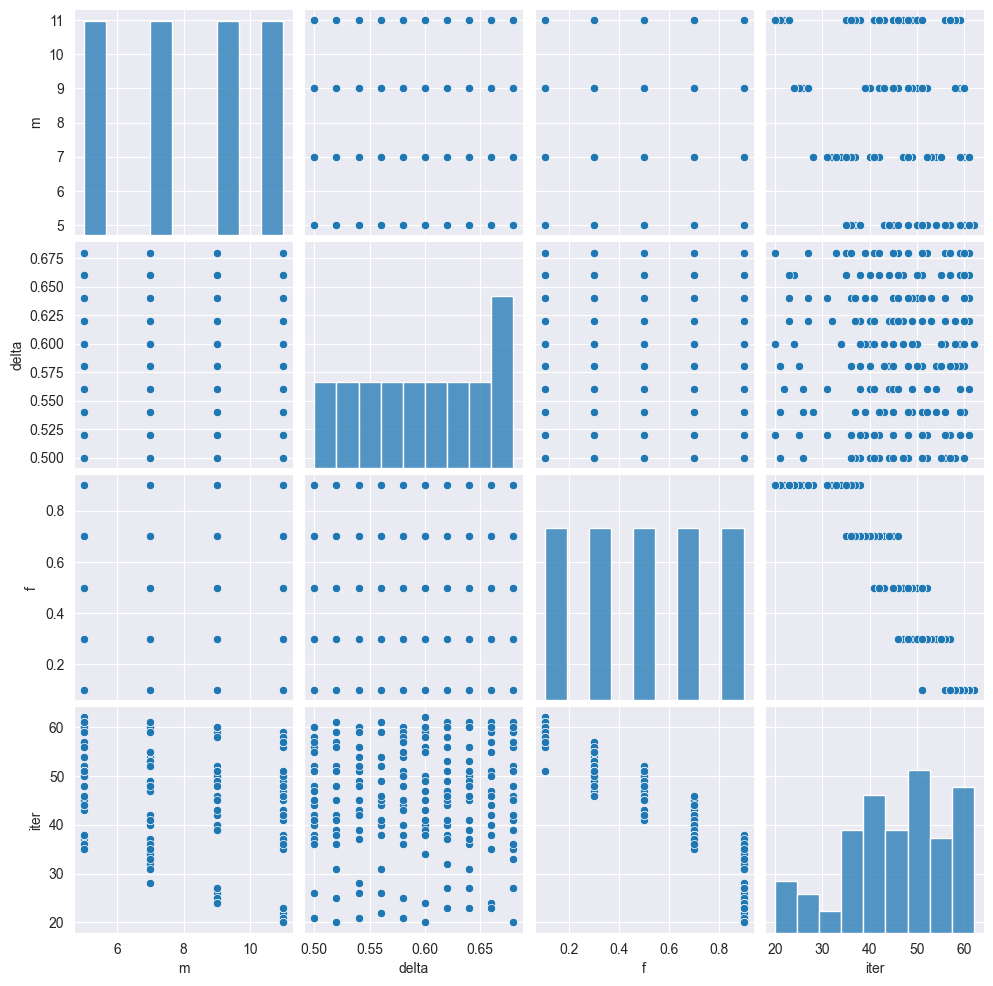

In [19]:
sns.pairplot(data_collector)

### m, delta and f relation
After having obtained the number of iterations for different combinations of $m$, $\Delta$ and $f$ a neural network was trained to predict the number of iterations needed for the system to converge to a low risk state.
To find the model a grid search was used. All possible combination of hyperparameter are selected and a multilayer perceptron is trained with the selected hyperparameters. The model with the best mean squared error (estimated with a 5-fold cross validation on training data) is selected and the performance of the model is compared with the test set to check for possible overfitting.

In [22]:
# training of neural network model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


In [62]:
X, y = data_collector.iloc[:,[0,1,2]], data_collector.iloc[:,4]

IndexError: single positional indexer is out-of-bounds

In [29]:
scaler = MinMaxScaler(copy=False, feature_range=(-1,1)).fit(X)
scaled_X = pd.DataFrame(scaler.transform(X), index=X.index)
scaled_X.columns = X.columns

In [30]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y, test_size=0.25, random_state=42)

In [20]:
from sklearn.model_selection import GridSearchCV
import math

def gs_regression_mae(model, par) :
    gs = GridSearchCV(model, par,cv=5,scoring ='neg_mean_squared_error')
    gs = gs.fit(X_train,y_train)

    #summarize the results of your GRIDSEARCH
    print('***GRIDSEARCH RESULTS***')
    print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']
    params = gs.cv_results_['params']


    y_pred_train=gs.predict(X_train)
    y_pred_test=gs.predict(X_test)


    from sklearn import metrics
    print()
    print("MSE  train %.3f              test %.3f" % (metrics.mean_squared_error(y_train, y_pred_train), metrics.mean_squared_error(y_test, y_pred_test)) )
    print("RMSE train %.3f              test %.3f" % (np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))) )
    print("r2   train %.3f              test %.3f" % (metrics.r2_score(y_train, y_pred_train), metrics.r2_score(y_test, y_pred_test)) )

In [31]:
# training of model
mlp_reg = MLPRegressor(random_state=42)
mlp_parameter = {'hidden_layer_sizes':[(10,5),(10,10,3),(20,10,5)],
                 'activation':['relu','logistic','tanh'],
                 'solver':['sgd','adam'],
                 'learning_rate':['constant'],
                 'alpha': [0.1,0.01,0.001],
                 'max_iter':[10000]}
gs_regression_mae(mlp_reg, mlp_parameter)

C:\Users\masch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\masch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\masch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\masch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the 

***GRIDSEARCH RESULTS***
Best score: -2.994285 using {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (20, 10, 5), 'learning_rate': 'constant', 'max_iter': 5000, 'solver': 'adam'}

MSE  train 2.452              test 2.649
RMSE train 1.566              test 1.628
r2   train 0.979              test 0.979


### Final model
The best model resulted in a neural network that can explain almost 98% of the variability of the number of iterations to converge.

In [34]:
# best model
best_mlp_regressor = MLPRegressor(solver='adam', max_iter=5000, learning_rate='constant', hidden_layer_sizes=(20,10,5), alpha=0.1, activation='relu')

In [35]:
# refit on all data
best_mlp_regressor.fit(scaled_X,y)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(20, 10, 5), max_iter=5000)

In [39]:
iters = flow_control(f=0.1, m=5, n=100, k=200, components=6, delta_start= 0.50)

##########
The system is not in control
Delta : 0.50
##########
##########
The system is not in control
Delta : 0.51
##########
##########
The system is not in control
Delta : 0.52
##########
##########
The system is not in control
Delta : 0.53
##########
##########
The system is not in control
Delta : 0.54
##########
##########
The system is not in control
Delta : 0.55
##########
##########
The system is not in control
Delta : 0.56
##########
##########
The system is not in control
Delta : 0.57
##########
##########
The system is not in control
Delta : 0.58
##########
##########
The system is not in control
Delta : 0.59
##########
##########
The system is not in control
Delta : 0.60
##########
##########
The system is not in control
Delta : 0.61
##########
##########
The system is not in control
Delta : 0.62
##########
##########
The system is not in control
Delta : 0.63
##########
##########
The system is not in control
Delta : 0.64
##########
##########
The system is not in control


In [40]:
iters

16

In [37]:
data_sim = pd.DataFrame(data={'m':[5], 'delta':[0.50], 'f':[0.1]})

In [38]:
best_mlp_regressor.predict(data_sim)

array([52.37143881])